In [9]:
import sys
!{sys.executable} -m pip install pydicom

!{sys.executable} -m pip install scikit-image

!{sys.executable} -m pip install SimpleITK



FloatSlider(value=60.0, description='angle interval', max=180.0)

IntSlider(value=80, description='det. number')

FloatSlider(value=100.0, description='ang. extent', max=180.0)

Button(description='Run parallel', style=ButtonStyle())

Button(description='Run conical', style=ButtonStyle())

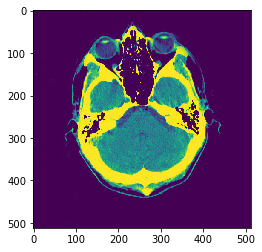

interactive(children=(IntSlider(value=0, description='x', max=3), Output()), _dom_classes=('widget-interact',)…

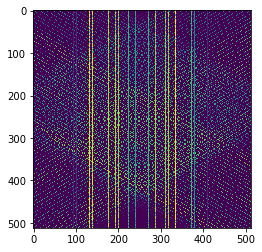

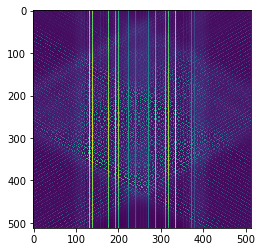

Setting file meta information...
Setting dataset values...
Writing test file C:\Users\BIJBOL~1\AppData\Local\Temp\tmp6sx4tf7q.dcm
File saved.
Writing test file as Big Endian Explicit VR C:\Users\BIJBOL~1\AppData\Local\Temp\tmpozxkwtdk.dcm


In [11]:
from abc import abstractmethod

from bresenham import bresenham
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipykernel.pylab.backend_inline import flush_figures
from skimage import filters, io
from skimage.restoration import denoise_nl_means, estimate_sigma
from IPython.display import display
import math

import os
import tempfile
import datetime

import pydicom
from pydicom.dataset import Dataset, FileDataset

import SimpleITK as sitk


#------------------------- CT "abstract" class
class CT:
    def __init__(self, filepath, withAnimation):
        self.imgToProcess = self.readProcessedImage(filepath)
        self.showImgToProcess()
        self.sinogram = None
        self.resultImage = None
        self.mapOfTransitions = None
        self.circleCoords = self.computeCircleEquation()
        self.withAnimation = withAnimation
        self.resultStepByStep = None
        self.mapOfTransitionsStepByStep = None

    @abstractmethod
    def transformSinogramToResultImage(self, angleInterval, angularExtent):
        pass

    def doCT(self, angleInterval, angularExtent, detectorsNumber):
        self.createSinogram(angleInterval, angularExtent, detectorsNumber)
        #self.drawSinogram()
        self.transformSinogramToResultImage(angleInterval, angularExtent)
        self.divideByTransitionNumber()
        self.drawResultImage()

    def addLineToResult(self, hPos, dPos, value):
        transitionPoints = list(bresenham(hPos[0], hPos[1], dPos[0], dPos[1]))
        for point in transitionPoints:
            if 0 <= point[0] < self.imgToProcess.shape[0] and 0 <= point[1] < self.imgToProcess.shape[1]:
                self.mapOfTransitions[point[0]][point[1]] += 1
                self.resultImage[point[0]][point[1]] += value

    def divideByTransitionNumber(self):
        for i in range(self.resultImage.shape[0]):
            for j in range(self.resultImage.shape[1]):
                if self.mapOfTransitions[i][j] != 0:
                    self.resultImage[i][j] /= self.mapOfTransitions[i][j]
                else:
                    self.resultImage[i][j] = 0

    def computeDetectedValue(self, hPos, dPos):
        transitionPoints = list(bresenham(hPos[0], hPos[1], dPos[0], dPos[1]))
        sumOfBrightness = 0
        numberOfIncludedPixels = 0
        for point in transitionPoints:
            if 0 < point[0] < self.imgToProcess.shape[0] and 0 < point[1] < self.imgToProcess.shape[1]:
                numberOfIncludedPixels += 1
                sumOfBrightness += self.imgToProcess[point[0]][point[1]]
        if numberOfIncludedPixels > 0:
            return sumOfBrightness / numberOfIncludedPixels
        return 0

    def readProcessedImage(self, filepath):
        return mpimg.imread(filepath)

    def drawResultImage(self):
        plt.imshow(self.resultImage)
        plt.show()
        
        estimatedSigma = np.mean(estimate_sigma(self.resultImage, multichannel=True))

        self.resultImage = denoise_nl_means(self.resultImage, h=0.8 * estimatedSigma, fast_mode=True)
        plt.imshow(self.resultImage)
        plt.show()


    def drawSinogram(self):
        plt.imshow(self.sinogram)
        plt.show()

    def showImgToProcess(self):
        plt.imshow(self.imgToProcess)
        plt.show()

    def computeCircleEquation(self):
        coords = list(map(lambda x: x / 2, self.imgToProcess.shape))
        radius = (coords[0] ** 2 + coords[1] ** 2) ** 0.5
        return {'x': coords[0], 'y': coords[1], 'r': radius}

    def getDevicePosition(self, alpha):
        x = self.circleCoords['x'] + self.circleCoords['r'] * np.cos(alpha)
        y = self.circleCoords['y'] + self.circleCoords['r'] * np.sin(alpha)
        return [int(x), int(y)]

    @abstractmethod
    def createSinogram(self, angleInterval, angularExtent, detectorsNumber):
        pass
    
    def on_change(self, x=0):
        io.imshow(self.resultStepByStep[x])
        flush_figures()
        
    def normalizeStep(self, step):
        for x in range(len(self.mapOfTransitionsStepByStep[step])):
            for y in range(len(self.mapOfTransitionsStepByStep[step][x])):
                if self.mapOfTransitionsStepByStep[step][x][y] != 0:
                    self.resultStepByStep[step][x][y] /= self.mapOfTransitionsStepByStep[step][x][y]

    def getResultImage(self):
        return self.resultImage
#------------------------- Conical CT class
class ConicalCT(CT):
    def __init__(self, filepath, withAnimation=False):
        super().__init__(filepath, withAnimation)

    def transformSinogramToResultImage(self, angleInterval, angularExtent):
        self.resultImage = np.zeros(self.imgToProcess.shape)
        self.mapOfTransitions = np.zeros(self.imgToProcess.shape)
        if self.withAnimation:
            self.resultStepByStep = [np.zeros(self.imgToProcess.shape)]
            self.mapOfTransitionsStepByStep = [np.zeros(self.imgToProcess.shape)]
        for i in range(self.sinogram.shape[0]):
            headerPosition = self.getDevicePosition(angleInterval * i)
            for j in range(self.sinogram.shape[1]):
                detectorPosition = self.getDevicePosition(
                    angleInterval * i + np.pi - angularExtent / 2 + j * angularExtent / self.sinogram.shape[1])
                self.addLineToResult(headerPosition, detectorPosition, self.sinogram[i][j])
            if self.withAnimation:
                self.resultStepByStep.append(self.resultImage.copy())
                self.normalizeStep(i)
                self.mapOfTransitionsStepByStep.append(self.mapOfTransitions.copy())
        if self.withAnimation:
            widgets.interact(self.on_change, x=(0,len(self.resultStepByStep) - 1, 1))

    def createSinogram(self, angleInterval, angularExtent, detectorsNumber):
        self.sinogram = np.zeros((int(2 * np.pi / angleInterval), detectorsNumber))
        for headerAngle, i in zip(np.arange(0, 2 * np.pi, angleInterval), range(int(2 * np.pi / angleInterval))):
            headerPosition = self.getDevicePosition(headerAngle)
            for detectorAngle, j in zip(np.arange(headerAngle + np.pi - angularExtent / 2,
                                                  headerAngle + np.pi + angularExtent / 2,
                                                  angularExtent / detectorsNumber), range(detectorsNumber)):
                detectorPosition = self.getDevicePosition(detectorAngle)
                self.sinogram[i][j] = self.computeDetectedValue(headerPosition, detectorPosition)


#------------------------- Parallel CT class
class ParallelCT(CT):
    def __init__(self, filepath, withAnimation=False):
        super().__init__(filepath, withAnimation)

    def transformSinogramToResultImage(self, angleInterval, angularExtent):
        self.resultImage = np.zeros(self.imgToProcess.shape)
        self.mapOfTransitions = np.zeros(self.imgToProcess.shape)
        if self.withAnimation:
            self.resultStepByStep = [np.zeros(self.imgToProcess.shape)]
            self.mapOfTransitionsStepByStep = [np.zeros(self.imgToProcess.shape)]
        for i in range(self.sinogram.shape[0]):
            for j in range(self.sinogram.shape[1]):
                emitterPosition = self.getDevicePosition(angleInterval * i - angularExtent / 2 + j * angularExtent / self.sinogram.shape[1])
                detectorPosition = self.getDevicePosition(angleInterval * i + np.pi + angularExtent / 2 - j * angularExtent / self.sinogram.shape[1])
                self.addLineToResult(emitterPosition, detectorPosition, self.sinogram[i][j])
            if self.withAnimation:
                self.resultStepByStep.append(self.resultImage.copy())
                self.normalizeStep(i)
                self.mapOfTransitionsStepByStep.append(self.mapOfTransitions.copy())
        if self.withAnimation:
            widgets.interact(self.on_change, x=(0,len(self.resultStepByStep) - 1, 1))

    def createSinogram(self, angleInterval, angularExtent, detectorsNumber):
        self.sinogram = np.zeros((int(np.pi / angleInterval), detectorsNumber))
        for centralPoint, i in zip(np.arange(0, np.pi, angleInterval), range(int(np.pi / angleInterval))):
            for j in range(detectorsNumber):
                emitterAngle = self.getDevicePosition(centralPoint - angularExtent / 2 + j * angularExtent / detectorsNumber)
                detectorPosition = self.getDevicePosition(centralPoint + np.pi + angularExtent / 2 - j * angularExtent / detectorsNumber)
                self.sinogram[i][j] = self.computeDetectedValue(emitterAngle, detectorPosition)
    
           
# to receive pretty good image for ConicalCT you have to use angular extend close to 180 degree              
#p = ParallelCT('ct_scan.png', withAnimation=True)
#p.doCT(np.pi / 30, np.pi/2.3, 100)
#p = ConicalCT('ct_scan.png' , withAnimation=True)
#p.doCT(np.pi / 30, np.pi/1.2, 100)

def saveDicom(img, path):
    # Create some temporary filenames
    suffix = '.dcm'
    filename_little_endian = tempfile.NamedTemporaryFile(suffix=suffix).name
    filename_big_endian = tempfile.NamedTemporaryFile(suffix=suffix).name

    print("Setting file meta information...")
    # Populate required values for file meta information
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
    file_meta.MediaStorageSOPInstanceUID = "1.2.3"
    file_meta.ImplementationClassUID = "1.2.3.4"

    print("Setting dataset values...")
    # Create the FileDataset instance (initially no data elements, but file_meta
    # supplied)
    ds = FileDataset(filename_little_endian, {},
                     file_meta=file_meta, preamble=b"\0" * 128)

    # Add the data elements -- not trying to set all required here. Check DICOM
    # standard
    ds.PatientName = "Test^Firstname"
    ds.PatientID = "123456"
    ds.PixelData = img.astype(np.uint16).tobytes()

    # Set the transfer syntax
    ds.is_little_endian = True
    ds.is_implicit_VR = True

    # Set creation date/time
    dt = datetime.datetime.now()
    ds.ContentDate = dt.strftime('%Y%m%d')
    timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
    ds.ContentTime = timeStr

    print("Writing test file", filename_little_endian)
    ds.save_as(filename_little_endian)
    print("File saved.")

    # Write as a different transfer syntax XXX shouldn't need this but pydicom
    # 0.9.5 bug not recognizing transfer syntax
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRBigEndian
    ds.is_little_endian = False
    ds.is_implicit_VR = False

    print("Writing test file as Big Endian Explicit VR", filename_big_endian)
    ds.save_as(path)

angleIntervalWidget = widgets.FloatSlider(description="angle interval", min=0, max=180, value=60)
detectorsNumberWidget = widgets.IntSlider(description="det. number", value=80)
angularExtentWidget = widgets.FloatSlider(description="ang. extent", min=0, max=180, value=100)

runParallelWidget = widgets.Button(description="Run parallel")
runConicalWidget = widgets.Button(description="Run conical")

def runParallel(x):
    flush_figures()
    angleInterval = angleIntervalWidget.value * math.pi / 180
    detectorsNumber = detectorsNumberWidget.value
    angularExtent = angularExtentWidget.value * math.pi / 180
    
    p = ParallelCT('ct_scan.png', withAnimation=True)
    p.doCT(angleInterval, angularExtent, detectorsNumber)
    
    saveDicom(p.getResultImage(),'patient.dcm')

def runConical(x):
    flush_figures()
    
    angleInterval = angleIntervalWidget.value * math.pi / 180
    detectorsNumber = detectorsNumberWidget.value
    angularExtent = angularExtentWidget.value * math.pi / 180
    
    p = ConicalCT('ct_scan.png' , withAnimation=True)
    p.doCT(angleInterval, angularExtent, detectorsNumber)
    
    saveDicom(p.getResultImage(),'patient.dcm')
    
runParallelWidget.on_click(runParallel)
runConicalWidget.on_click(runConical)

display(angleIntervalWidget)
display(detectorsNumberWidget)
display(angularExtentWidget)

display(runParallelWidget)
display(runConicalWidget)
